A retail company “ABC Private Limited” wants to understand the customer purchase behaviour (specifically, purchase amount) against various products of different categories. They have shared purchase summary of various customers for selected high volume products from last month.
The data set also contains customer demographics (age, gender, marital status, city_type, stay_in_current_city), product details (product_id and product category) and Total purchase_amount from last month.

Now, they want to build a model to predict the purchase amount of customer against various products which will help them to create personalized offer for customers against different products.

Data
- Variable	Definition
- User_ID	User ID
- Product_ID	Product ID
- Gender	Sex of User
- Age	Age in bins
- Occupation	Occupation (Masked)
- City_Category	Category of the City (A,B,C)
- Stay_In_Current_City_Years	Number of years stay in current city
- Marital_Status	Marital Status
- Product_Category_1	Product Category (Masked)
- Product_Category_2	Product may belongs to other category also (Masked)
- Product_Category_3	Product may belongs to other category also (Masked)
- Purchase	Purchase Amount (Target Variable)

In [83]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [84]:
data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [85]:
df = data.copy()

In [86]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


## Exploratory Data Analysis

In [88]:
df.Purchase.describe()

count    550068.000000
mean       9263.968713
std        5023.065394
min          12.000000
25%        5823.000000
50%        8047.000000
75%       12054.000000
max       23961.000000
Name: Purchase, dtype: float64

In [89]:
def distributionplot(x = df,colname = None):
    plt.figure(figsize=(20,6))

    sns.set_style("white")
    sns.set_context("notebook",font_scale=2)

    plt.subplot(1,2,1)
    ax = sns.distplot(x[colname])
    ax.set_title("Distribution plot of {}".format(colname));

    plt.subplot(1,2,2)
    ax1 = sns.boxplot(x[colname])
    ax1.set_title("Box Whisker plot of {}".format(colname));

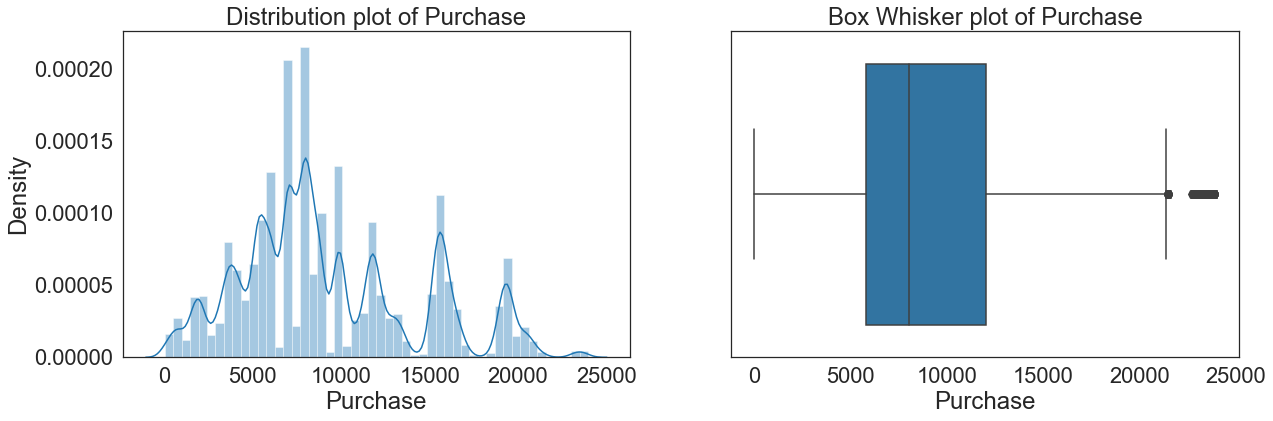

In [90]:
distributionplot(df,colname='Purchase')

In [91]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233599 entries, 0 to 233598
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     233599 non-null  int64  
 1   Product_ID                  233599 non-null  object 
 2   Gender                      233599 non-null  object 
 3   Age                         233599 non-null  object 
 4   Occupation                  233599 non-null  int64  
 5   City_Category               233599 non-null  object 
 6   Stay_In_Current_City_Years  233599 non-null  object 
 7   Marital_Status              233599 non-null  int64  
 8   Product_Category_1          233599 non-null  int64  
 9   Product_Category_2          161255 non-null  float64
 10  Product_Category_3          71037 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 19.6+ MB


In [92]:
df.drop(['User_ID', 'Product_ID'],axis=1,inplace=True)


In [93]:
test_data.drop(['User_ID', 'Product_ID'],axis=1,inplace=True)

In [94]:
print("All attributes with no. of missing value in data : ")
null_values = pd.DataFrame({'total_missing': df.isnull().sum(), '%_missing': df.isnull().mean()*100,
                           'datatype':df.dtypes})
null_values[null_values['total_missing']>0].sort_values('total_missing',ascending=False)

All attributes with no. of missing value in data : 


,total_missing,%_missing,datatype
Product_Category_3,383247,69.672659,float64
Product_Category_2,173638,31.566643,float64


In [95]:
df.Product_Category_2.value_counts()

8.0     64088
14.0    55108
2.0     49217
16.0    43255
15.0    37855
5.0     26235
4.0     25677
6.0     16466
11.0    14134
17.0    13320
13.0    10531
9.0      5693
12.0     5528
10.0     3043
3.0      2884
18.0     2770
7.0       626
Name: Product_Category_2, dtype: int64

In [96]:
df.Product_Category_2 = df.Product_Category_2.fillna(16.0)
df.Product_Category_3 = df.Product_Category_3.fillna(8.0)

In [97]:
test_data.Product_Category_2 = test_data.Product_Category_2.fillna(16.0)
test_data.Product_Category_3 = test_data.Product_Category_3.fillna(8.0)

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Gender                      550068 non-null  object 
 1   Age                         550068 non-null  object 
 2   Occupation                  550068 non-null  int64  
 3   City_Category               550068 non-null  object 
 4   Stay_In_Current_City_Years  550068 non-null  object 
 5   Marital_Status              550068 non-null  int64  
 6   Product_Category_1          550068 non-null  int64  
 7   Product_Category_2          550068 non-null  float64
 8   Product_Category_3          550068 non-null  float64
 9   Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 42.0+ MB


In [99]:
df.Stay_In_Current_City_Years.value_counts()

1     193821
2     101838
3      95285
4+     84726
0      74398
Name: Stay_In_Current_City_Years, dtype: int64

In [100]:
df.Stay_In_Current_City_Years = df.Stay_In_Current_City_Years.apply(lambda x: '4' if x == '4+' else x).astype(int)
test_data.Stay_In_Current_City_Years = test_data.Stay_In_Current_City_Years.apply(lambda x: '4' if x == '4+' else x).astype(int)

In [101]:
df.Marital_Status = df.Marital_Status.astype('O')
df.Occupation = df.Occupation.astype('O')
df.Product_Category_1 = df.Product_Category_1.astype('O')
df.Product_Category_2 = df.Product_Category_2.astype('O')
df.Product_Category_3 = df.Product_Category_3.astype('O')

In [102]:
test_data.Marital_Status = test_data.Marital_Status.astype('O')
test_data.Occupation = test_data.Occupation.astype('O')
test_data.Product_Category_1 = test_data.Product_Category_1.astype('O')
test_data.Product_Category_2 = test_data.Product_Category_2.astype('O')
test_data.Product_Category_3 = test_data.Product_Category_3.astype('O')

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   Gender                      550068 non-null  object
 1   Age                         550068 non-null  object
 2   Occupation                  550068 non-null  object
 3   City_Category               550068 non-null  object
 4   Stay_In_Current_City_Years  550068 non-null  int32 
 5   Marital_Status              550068 non-null  object
 6   Product_Category_1          550068 non-null  object
 7   Product_Category_2          550068 non-null  object
 8   Product_Category_3          550068 non-null  object
 9   Purchase                    550068 non-null  int64 
dtypes: int32(1), int64(1), object(8)
memory usage: 39.9+ MB


In [104]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233599 entries, 0 to 233598
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   Gender                      233599 non-null  object
 1   Age                         233599 non-null  object
 2   Occupation                  233599 non-null  object
 3   City_Category               233599 non-null  object
 4   Stay_In_Current_City_Years  233599 non-null  int32 
 5   Marital_Status              233599 non-null  object
 6   Product_Category_1          233599 non-null  object
 7   Product_Category_2          233599 non-null  object
 8   Product_Category_3          233599 non-null  object
dtypes: int32(1), object(8)
memory usage: 15.1+ MB


In [105]:
y = df.Purchase
x = df.drop('Purchase',axis=1)

In [106]:
x = pd.get_dummies(x)

In [107]:
x.shape

(550068, 88)

In [109]:
test_data_x = pd.get_dummies(test_data)

In [119]:
test_data_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233599 entries, 0 to 233598
Data columns (total 86 columns):
 #   Column                      Non-Null Count   Dtype
---  ------                      --------------   -----
 0   Stay_In_Current_City_Years  233599 non-null  int32
 1   Gender_F                    233599 non-null  uint8
 2   Gender_M                    233599 non-null  uint8
 3   Age_0-17                    233599 non-null  uint8
 4   Age_18-25                   233599 non-null  uint8
 5   Age_26-35                   233599 non-null  uint8
 6   Age_36-45                   233599 non-null  uint8
 7   Age_46-50                   233599 non-null  uint8
 8   Age_51-55                   233599 non-null  uint8
 9   Age_55+                     233599 non-null  uint8
 10  Occupation_0                233599 non-null  uint8
 11  Occupation_1                233599 non-null  uint8
 12  Occupation_2                233599 non-null  uint8
 13  Occupation_3                233599 non-null 

In [110]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 88 columns):
 #   Column                      Non-Null Count   Dtype
---  ------                      --------------   -----
 0   Stay_In_Current_City_Years  550068 non-null  int32
 1   Gender_F                    550068 non-null  uint8
 2   Gender_M                    550068 non-null  uint8
 3   Age_0-17                    550068 non-null  uint8
 4   Age_18-25                   550068 non-null  uint8
 5   Age_26-35                   550068 non-null  uint8
 6   Age_36-45                   550068 non-null  uint8
 7   Age_46-50                   550068 non-null  uint8
 8   Age_51-55                   550068 non-null  uint8
 9   Age_55+                     550068 non-null  uint8
 10  Occupation_0                550068 non-null  uint8
 11  Occupation_1                550068 non-null  uint8
 12  Occupation_2                550068 non-null  uint8
 13  Occupation_3                550068 non-null 

In [111]:
data_dmatrix = xgb.DMatrix(data=x,label=y)

In [112]:
x_train, x_val, y_train, y_val = train_test_split(x, y , test_size=0.3, random_state=2227)

In [113]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [114]:
xg_reg.fit(x_train,y_train)

preds = xg_reg.predict(x_val)

[19:38:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


In [115]:
rmse = np.sqrt(mean_squared_error(y_train,xg_reg.predict(x_train) ))
print("RMSE: %f" % (rmse))

RMSE: 5180.992129


In [116]:
rmse = np.sqrt(mean_squared_error(y_val, preds))
print("RMSE: %f" % (rmse))

RMSE: 5186.217522


In [117]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[19:38:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


In [118]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,9672.352214,8.583567,9672.375977,18.866204
1,8902.811524,28.663409,8903.041992,43.835248
2,8218.396484,23.572642,8217.931804,47.504366
3,7596.037109,19.637037,7595.109212,39.158807
4,7077.554850,25.989955,7077.026530,47.646123


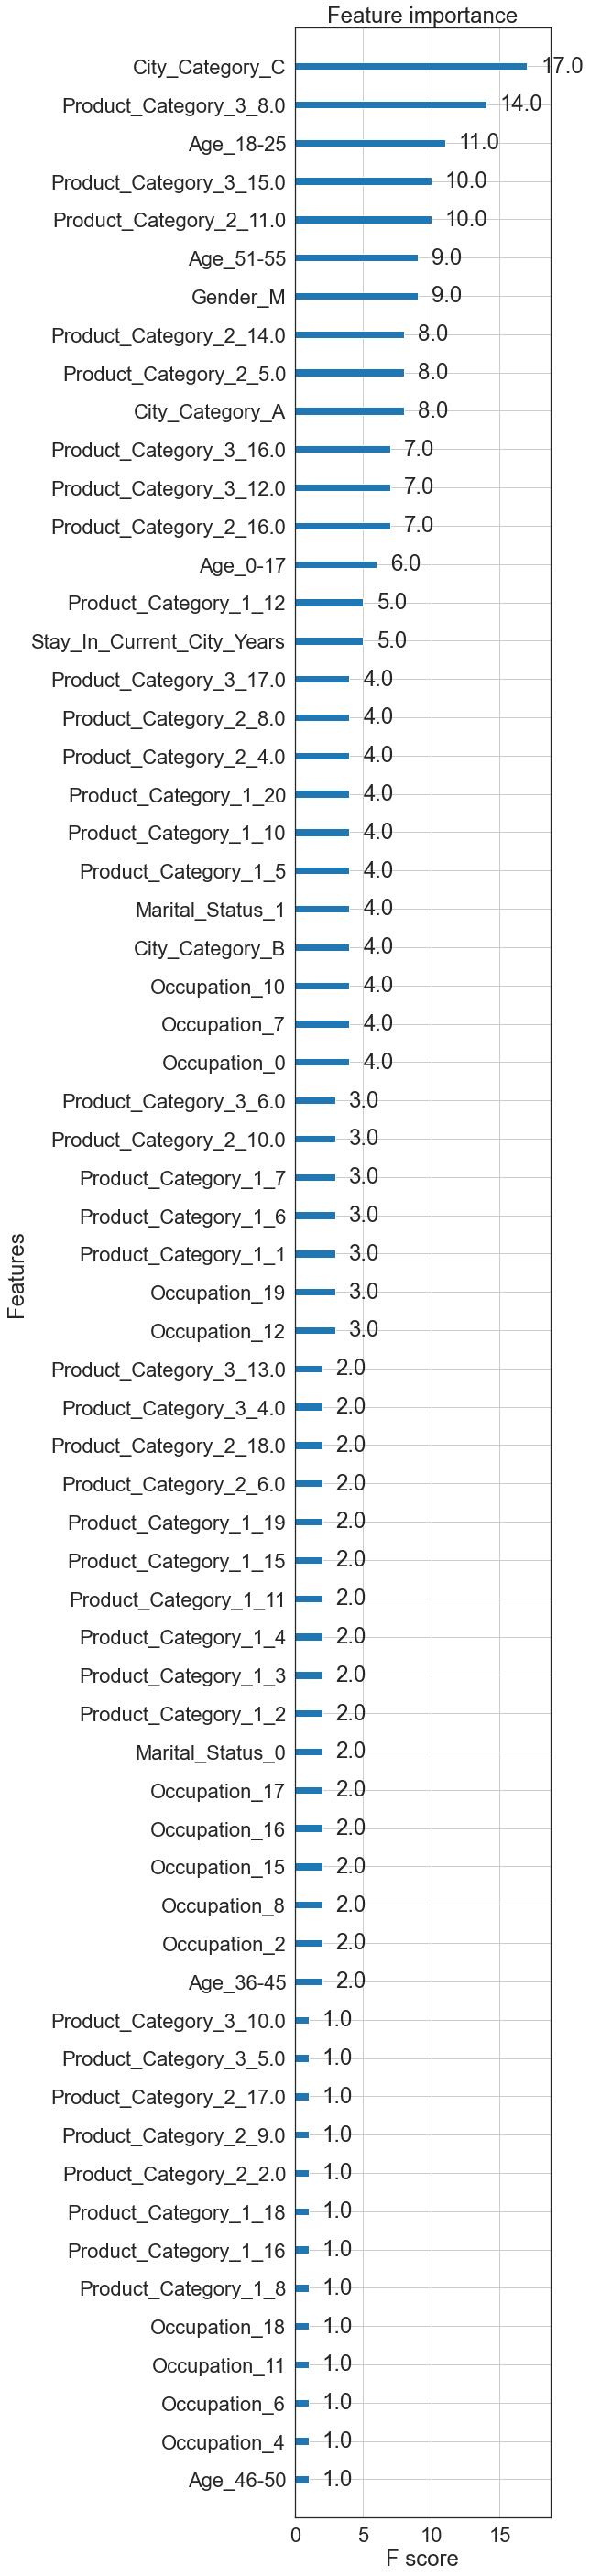

In [124]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [100, 5]
plt.show()

In [ ]:
pd.DataFrame({'Purchase':xg_reg.predict(test_data_x),'User_ID':data.User_ID,'Product_ID':data.Product_ID})